Forecasted Volatility for the last day in the horizon:
h.1    1.468939
h.2    1.489672
h.3    1.511515
h.4    1.533235
h.5    1.548655
Name: 2023-11-03 00:00:00-04:00, dtype: float64


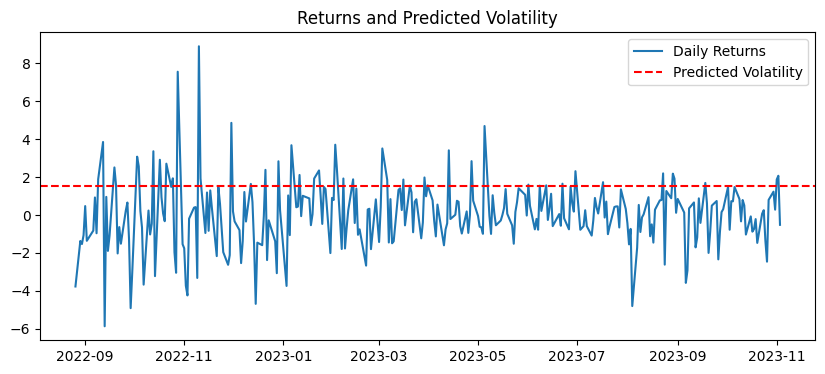

In [92]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

# Download historical data for a stock
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)
data = data.history(period='1d', start='2013-1-1', end='2023-11-04')

# Drop any rows that are completely NA
data.dropna(how='all', inplace=True)

# Calculate daily returns and drop the first NA
data['returns'] = 100 * data['Close'].pct_change().dropna()

# Check for infinite values which can happen if there is a 0 in close prices somehow
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NA values created by percentage change
data.dropna(inplace=True)

# Define the GARCH model
garch_model = arch_model(data['returns'], vol='Garch', p=1, q=1)

# Fit the model with try-except to catch errors
try:
    garch_fit = garch_model.fit(disp='off')  # Suppress optimization output

    # Forecast the volatility for the next 5 days
    forecasts = garch_fit.forecast(horizon=5, method='simulation')

    # Get the last day forecast
    last_day_forecast = forecasts.variance.iloc[-1]**0.5  # square root of variance

    # Ensure that we have finite values
    if np.all(np.isfinite(last_day_forecast)):

        # Print the forecasted volatility
        print("Forecasted Volatility for the last day in the horizon:")
        print(last_day_forecast)

        # Plot the last 100 days of returns and the forecasted volatility level
        plt.figure(figsize=(10, 4))
        plt.plot(data.index[-300:], data['returns'][-300:], label='Daily Returns')
        plt.title('Returns and Predicted Volatility')

        # Plot a horizontal line for the predicted volatility on the last day
        plt.axhline(y=last_day_forecast.values[-1], color='r', linestyle='--', label='Predicted Volatility')
        plt.legend()
        plt.show()
    else:
        print("The forecasted volatility contains non-finite values and cannot be plotted.")

except Exception as e:
    print(f"An error occurred: {e}")


Forecasted Volatility: 1.24%


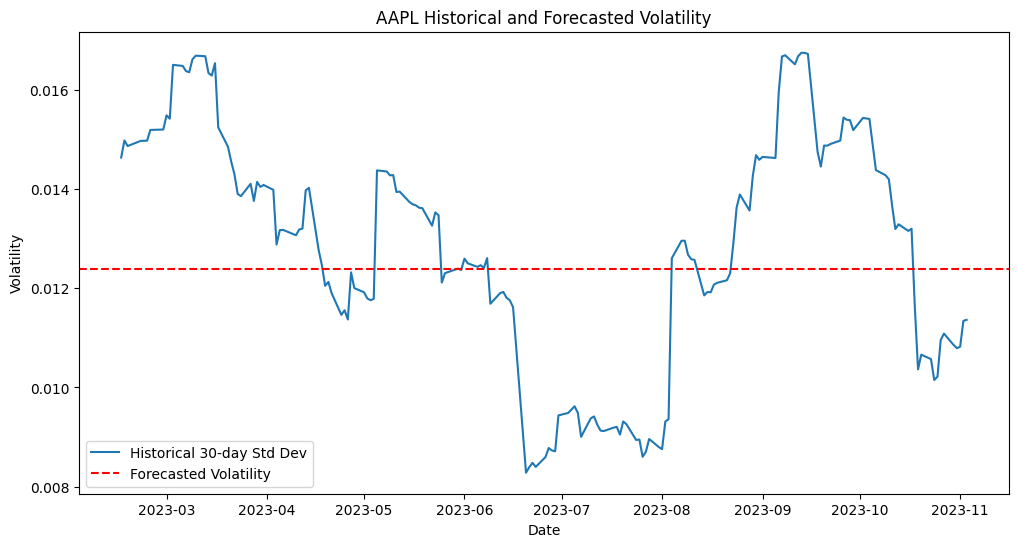

In [93]:
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
import numpy as np
import datetime

def get_historical_volatility(ticker_symbol, start_date, end_date):
    data = yf.Ticker(ticker_symbol).history(period='1d', start=start_date, end=end_date)
    data.dropna(how='all', inplace=True)
    data['returns'] = 100 * data['Close'].pct_change().dropna()
    data['volatility'] = data['returns'].rolling(window=30).std()
    return data/100

def get_garch_forecasted_volatility(ticker_symbol, start_date, end_date):
    # Fetch the historical data
    data = yf.Ticker(ticker_symbol).history(period='1d', start=start_date, end=end_date)
    data.dropna(how='all', inplace=True)
    
    # Calculate daily returns and multiply by 100 to express as percentage
    data['returns'] = data['Close'].pct_change().dropna() * 100
    
    # Remove infinite values and drop remaining NAs
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    
    # Fit the GARCH model
    garch_model = arch_model(data['returns'], vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    
    # Forecast the next day's variance
    forecasts = garch_fit.forecast(horizon=1)
    
    # Take the square root of the forecasted variance to get the standard deviation
    last_day_volatility = np.sqrt(forecasts.variance.iloc[-1])
    
    # Since we scaled the returns by 100, we need to scale back the volatility
    last_day_volatility_scaled = last_day_volatility / 100
    
    # Return the last day's forecasted daily volatility as a percentage
    return last_day_volatility_scaled.values[-1]

# Example usage of the functions
ticker_symbol = 'AAPL'
start_date = '2023-1-1'
end_date = '2023-11-04'
historical_data = get_historical_volatility(ticker_symbol, start_date, end_date)

# Get the forecasted volatility from GARCH
forecasted_volatility = get_garch_forecasted_volatility(ticker_symbol, start_date, end_date)
print(f"Forecasted Volatility: {forecasted_volatility:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['volatility'], label='Historical 30-day Std Dev')
plt.axhline(y=forecasted_volatility, color='r', linestyle='--', label='Forecasted Volatility')
plt.title('AAPL Historical and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [94]:
from scipy.optimize import fmin
from scipy.stats import norm
import numpy as np

# Assuming today's date is November 5, 2023, for this example
current_date = datetime.datetime(2023, 11, 5)
expiration_date = datetime.datetime(2023, 11, 17)

# Provided data
S = 176.65  # Latest AAPL stock price
X = 175  # Strike price
r = 0.04  # Risk-free interest rate (annually)
T = (expiration_date - current_date).days / 365  # Time to expiration in years
cm = 3.1  # Market price of the option

# Adjusted function for a call option
def ImpliedVolatilityCall(s):
    d1 = ((np.log(S/X) + (r + 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
    d2 = ((np.log(S/X) + (r - 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    val = (call_price - cm)**2
    print("[σ]=", s, ", Object Function Value:", val)
    return val

# Initial guess for the volatility
initial_sigma = [0.3]  # Starting with an initial guess of 30%

# Using fmin to minimize the objective function and find the implied volatility
s = fmin(ImpliedVolatilityCall, initial_sigma)

# The result from fmin will be the implied volatility
iv_call = s[0]
print(f"Implied Volatility (Call): {iv_call:.2%}")


# Determine trading signals based on the forecasted and implied volatility
if forecasted_volatility > iv_call:
    print("Buy Signal: The GARCH model predicts higher volatility than the market implies.")
elif forecasted_volatility < iv_call:
    print("Sell Signal: The GARCH model predicts lower volatility than the market implies.")
else:
    print("No clear signal: The market's implied volatility matches the GARCH model's prediction.")

[σ]= [0.3] , Object Function Value: 2.9793038551166537
[σ]= [0.315] , Object Function Value: 3.660190991105922
[σ]= [0.285] , Object Function Value: 2.369521524072218
[σ]= [0.27] , Object Function Value: 1.8306076800004638
[σ]= [0.24] , Object Function Value: 0.9641420002724339
[σ]= [0.21] , Object Function Value: 0.37654231981853675
[σ]= [0.15] , Object Function Value: 0.011643879980543514
[σ]= [0.09] , Object Function Value: 0.6063510434829859
[σ]= [0.09] , Object Function Value: 0.6063510434829859
[σ]= [0.18] , Object Function Value: 0.062274818742572416
[σ]= [0.12] , Object Function Value: 0.20616465011360538
[σ]= [0.165] , Object Function Value: 0.004868635577018243
[σ]= [0.18] , Object Function Value: 0.062274818742572416
[σ]= [0.1575] , Object Function Value: 0.00037491571896505413
[σ]= [0.15] , Object Function Value: 0.011643879980543514
[σ]= [0.16125] , Object Function Value: 0.0006318741248894211
[σ]= [0.15375] , Object Function Value: 0.004059505000015895
[σ]= [0.159375] , O

In [95]:
# from scipy.optimize import fmin
# from scipy.stats import norm
# import numpy as np

# # Provided data
# S = 176.65  # Latest VOO stock price
# X = 175  # Strike price
# r = 0.04  # Risk-free interest rate (annually)
# T = (expiration_date - current_date).days / 365  # Time to expiration in years
# cm = 3.1  # Market price of the option

# # Adjusted function for a call option
# def ImpliedVolatilityCall(s):
#     d1 = ((np.log(S/X) + (r + 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
#     d2 = ((np.log(S/X) + (r - 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
#     call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
#     val = (call_price - cm)**2
#     print("[σ]=", s, ", Object Function Value:", val)
#     return val

# # Initial guess for the volatility
# initial_sigma = [0.3]  # Starting with an initial guess of 30%

# # Using fmin to minimize the objective function and find the implied volatility
# s = fmin(ImpliedVolatilityCall, initial_sigma)

# # The result from fmin will be the implied volatility
# iv_call = s[0]
# print(f"Implied Volatility (Call): {iv_call:.2%}")


Backtest

In [100]:
def get_implied_volatility(s, S, X, r, T, cm):
    # s is the volatility, the other parameters as per your functions above
    d1 = ((np.log(S/X) + (r + 0.5 * s**2) * T) / (s * np.sqrt(T)))
    d2 = ((np.log(S/X) + (r - 0.5 * s**2) * T) / (s * np.sqrt(T)))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return (call_price - cm)**2

def call_option_price(s, S, X, r, T):
    d1 = ((np.log(S/X) + (r + 0.5 * s**2) * T) / (s * np.sqrt(T)))
    d2 = d1 - s * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def objective_function(s, S, X, r, T, cm):
    # This is the objective function that fmin will minimize
    return (call_option_price(s, S, X, r, T) - cm)**2

def backtest_strategy(data, risk_free_rate, strike_price):
    # Assuming 'data' is a DataFrame with 'Close' prices and corresponding 'Option' market prices

    data['returns'] = data['Close'].pct_change().dropna()

    data['hist_vol'] = get_historical_volatility(data)

    data['garch_vol'] = np.nan
    data['implied_vol'] = np.nan
    data['signal'] = 0

    cash = 10000
    position = 0
    portfolio_values = []

    for index, row in data.iterrows():
        # GARCH forecasted volatility (the function should return a scalar value)
        row['garch_vol'] = get_garch_forecasted_volatility(data['returns'].loc[:index])

        # Calculate time to expiration in years
        T = (data.index[-1] - index).days / 365

        # Find the implied volatility for the day
        # This assumes that the option market price is stored in the DataFrame under a column 'Option'
        cm = row['Option']
        row['implied_vol'] = fmin(lambda s: objective_function(s, row['Close'], strike_price, risk_free_rate, T, cm), 0.2, disp=False)[0]

        # Generate signals based on the volatilities
        if row['garch_vol'] > row['implied_vol']:
            data.at[index, 'signal'] = 1
        elif row['garch_vol'] < row['implied_vol']:
            data.at[index, 'signal'] = -1

        # Execute trade based on signal
        if data.at[index, 'signal'] == 1 and cash >= row['Close']:
            position += 1
            cash -= row['Close']
        elif data.at[index, 'signal'] == -1 and position > 0:
            position -= 1
            cash += row['Close']

        # Update the current portfolio value
        portfolio_value = cash + position * row['Close']
        portfolio_values.append(portfolio_value)

    data['portfolio_value'] = pd.Series(portfolio_values, index=data.index)

    # Plot the portfolio value over time
    plt.figure(figsize=(14, 7))
    plt.plot(data['portfolio_value'], label='Portfolio Value')
    plt.plot(data['Close'], label='Stock Price', alpha=0.5)
    plt.title('Portfolio Value and Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# You'd call the function like this, assuming you have already loaded 'data' with the right columns:
backtest_strategy(data, risk_free_rate=0.01, strike_price=175)

ValueError: NaN or inf values found in y. y must contains only finite values.